# Подключение гугл диска

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Импорт библиотек

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error
from sklearn.linear_model import SGDRegressor

import seaborn as sns
import matplotlib.pyplot as plt

# Загрузка данных

In [ ]:
# Чтобы выполнить загрузку, нужно положить данные на свой гугл диск
data0 = pd.read_csv('/content/drive/MyDrive/geo_data_0.csv', sep=',')
data1 = pd.read_csv('/content/drive/MyDrive/geo_data_1.csv', sep=',')
data2 = pd.read_csv('/content/drive/MyDrive/geo_data_2.csv', sep=',')

In [ ]:
data2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


# Предобработка

## Сведение

Представим, как модель будет работать на новых данных. По сути, на входе мы имеем несколько регионов, и для каждого нужно сделать свой прогноз. Поэтому в процессе сведения нужно не потерять информацию о регионе, либо отщепить выборки зарананее. Поступим следующим образом - добавим признак региона в каждый датасет и склеим все три датасета

In [ ]:
data0['region'] = 'first'
data1['region'] = 'second'
data2['region'] = 'third'

data = pd.concat([data0, data1, data2])
data.head()

,id,f0,f1,f2,product,region
0,txEyH,0.705745,-0.497823,1.221170,105.280062,first
1,2acmU,1.334711,-0.340164,4.365080,73.037750,first
2,409Wp,1.022732,0.151990,1.419926,85.265647,first
3,iJLyR,-0.032172,0.139033,2.978566,168.620776,first
4,Xdl7t,1.988431,0.155413,4.751769,154.036647,first


## Пропуски

Выведем полную информацию о датафрейме

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       300000 non-null  object 
 1   f0       300000 non-null  float64
 2   f1       300000 non-null  float64
 3   f2       300000 non-null  float64
 4   product  300000 non-null  float64
 5   region   300000 non-null  object 
dtypes: float64(4), object(2)
memory usage: 16.0+ MB


Посмотрим на пропущенные значения

In [ ]:
data.isnull().sum()

id         0
f0         0
f1         0
f2         0
product    0
region     0
dtype: int64

Пропусков нет

## Преобразование типов

Все типы корректны. Вроде бы с object у нас нет больших проблем, но в случае чего можно будет поменять их на строки

## Дубликаты

In [ ]:
data.duplicated(keep=False)

0        False
1        False
2        False
3        False
4        False
         ...  
99995    False
99996    False
99997    False
99998    False
99999    False
Length: 300000, dtype: bool

Дубликатов нет

## Значения, не отражающие действительность

Выведем статистики числовых столбцов

In [ ]:
data.describe()

,f0,f1,f2,product
count,300000.000000,300000.000000,300000.000000,300000.000000
mean,0.547913,-1.516172,2.497439,85.441667
std,5.316634,3.900220,2.916502,46.519494
min,-31.609576,-26.358598,-12.088328,0.000000
25%,-1.003037,-2.478939,0.648213,52.666629
50%,0.347934,-0.229632,2.491215,84.038886
75%,1.755365,0.678562,4.344943,124.174086
max,29.421755,18.734063,16.739402,190.029838


Настараживает нулевой минимум для product - возможно, какие-то пропуски кодировались нулями. Посмотрим на распределение

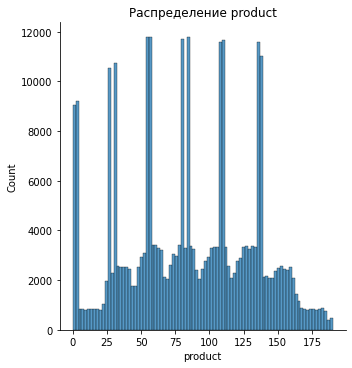

In [ ]:
sns.displot(
  data=data['product'],
  kde=False,
  common_norm=False)

plt.title('Распределение product');

Зависимость выглядит крайне интересно, но нулевая точка не экстремальная, значит, видимо, это реальное значение

В целом, данные чистые, выглядит как будто здесь не нужна никакая предобработка. Выбросов нет, распределение даже чем-то напоминает нормальное. Передём к моделированию

# Построение модели

Метод для вывода метрик

In [ ]:
def r2_adjusted(y_true: list, y_pred: list, X_test: np.array) -> float:
    N_objects = len(y_true)
    N_features = X_test.shape[1]
    r2 = r2_score(y_true, y_pred)
    return 1 - (1 - r2) * (N_objects - 1) / (N_objects - N_features - 1)


def mpe(y_true: list, y_pred: list) -> float:
    return np.mean((y_true - y_pred)/ y_true)


def mape(y_true: list, y_pred: list) -> float:
    return np.mean(np.abs((y_pred - y_true) / y_true))


def wape(y_true: list, y_pred: list) -> float:
    return np.sum(np.abs(y_pred - y_true)) / np.sum(y_true)


def huber_loss(y_true, y_pred, delta):
    assert len(y_true) == len(y_pred), 'Разные размеры данных'
    huber_sum = 0
    for i in range(len(y_true)):
        if abs(y_true[i] - y_pred[i]) <= delta:
            huber_sum += 0.5 * (y_true[i] - y_pred[i])**2
        else:
            huber_sum += delta * (0.5 * abs(y_true[i] - y_pred[i]) -
                                  0.5 * delta)
    huber_sum /= len(y_true)
    return huber_sum


def rmsle(y_true: np.ndarray, y_pred: np.ndarray) -> np.float64:
    """
    The Root Mean Squared Log Error (RMSLE) metric 
    Логаритмическая ошибка средней квадратичной ошибки
    """
    return np.sqrt(mean_squared_log_error(y_true, y_pred))


def get_metrics(y_test, y_pred, X_test, name, delta):
    df_metrics = pd.DataFrame()
    
    df_metrics['model'] = [name]
    
    df_metrics['MAE'] = [mean_absolute_error(y_test, y_pred)]
    df_metrics['MSE'] = [mean_squared_error(y_test, y_pred)]
    df_metrics['RMSE'] = [np.sqrt(mean_squared_error(y_test, y_pred))]
    try:
        df_metrics['RMSLE'] = [rmsle(y_test, y_pred)]
    except:
        df_metrics['RMSLE'] = 0

    df_metrics['R2 adjusted'] = [r2_adjusted(y_test, y_pred, X_test)]
    df_metrics['Huber_loss'] = [huber_loss(y_test, y_pred, delta)]
    df_metrics['MPE_%'] = [mpe(y_test, y_pred)*100]
    df_metrics['MAPE_%'] = [mape(y_test, y_pred)*100]
    df_metrics['WAPE_%'] = [wape(y_test, y_pred)*100]
    
    return df_metrics

Подготовим данные. Важный момент здесь состоит в том, что нужно не потерять регион, который не является признаком для обучения (т.к. мы, наверное, хотим предполагать, что модель можно масштабировать на неизвестные регионы). Поэтому оставим его для разбиения, а потом удалим отдельно для обучающей выборки

In [ ]:
del data['id']

feature_cols = data.drop(columns = ['product'])

X_train, X_test, y_train, y_test = train_test_split(feature_cols,
                                                    data['product'],
                                                    test_size=0.25,
                                                    random_state=10,
                                                    shuffle=True)

In [ ]:
X_train = X_train.drop(columns = ['region'])

Обучим линейную регрессию с базовыми гиперпараметрами

In [ ]:
lr = SGDRegressor()
lr.fit(X_train, y_train)

SGDRegressor()

Сделаем предикт на тестовой выборке и выведем метрики


In [ ]:
y_pred = lr.predict(X_test.drop(columns=['region']))

metrics = get_metrics(list(y_test), y_pred, X_test, name='SGDRegressor', delta=10)
metrics

<ipython-input-11-28dbcd904a55>:9: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean((y_true - y_pred)/ y_true)
<ipython-input-11-28dbcd904a55>:13: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_pred - y_true) / y_true))


,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,Huber_loss,MPE_%,MAPE_%,WAPE_%
0,SGDRegressor,31.772793,1509.406595,38.851082,0,0.305338,116.493752,-inf,inf,37.136392


Часть метрик сломалась из-за нулевых значений - в идеале бы заменить их на какие-нибудь eps, но не будем заморачиваться, т.к. всё равно для задания нужно только RMSE

Теперь подберём гиперпараметры

In [ ]:
param_grid = {
    'alpha': 10.0 ** -np.arange(1, 7),
    'loss': ['squared_loss', 'huber', 'epsilon_insensitive'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'learning_rate': ['constant', 'optimal', 'invscaling'],
}
clf = GridSearchCV(lr, param_grid)
clf.fit(X_train, y_train)
print("Best score: " + str(clf.best_score_))

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'squared_loss' was deprecated in v1.0 and will be removed in version 1.2. Use `loss='squared_error'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'squared_loss' was deprecated in v1.0 and will be removed in version 1.2. Use `loss='squared_error'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'squared_loss' was deprecated in v1.0 and will be removed in version 1.2. Use `loss='squared_error'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'squared_loss' was deprecated in v1.0 and will be removed in version 1.2. Use `loss='squared_error'` which is equivalent.
  warning

Best score: 0.30451272981977473


In [ ]:
y_pred = clf.predict(X_test.drop(columns=['region']))

metrics = metrics.append(get_metrics(list(y_test), y_pred, X_test, name='SGDRegressor_grid', delta=10))
metrics

<ipython-input-11-28dbcd904a55>:9: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean((y_true - y_pred)/ y_true)
<ipython-input-11-28dbcd904a55>:13: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_pred - y_true) / y_true))


,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,Huber_loss,MPE_%,MAPE_%,WAPE_%
0,SGDRegressor,31.772793,1509.406595,38.851082,0,0.305338,116.493752,-inf,inf,37.136392
0,SGDRegressor_grid,31.715901,1505.139751,38.796131,0,0.307301,116.206957,-inf,inf,37.069896


Не особо что-то улучшилось, хотя ошибка всё же немного упала. Сделаем предикт на обучающей выборке

In [ ]:
y_pred_train = clf.predict(X_train)

metrics = metrics.append(get_metrics(list(y_train), y_pred_train, X_train, name='SGDRegressor_grid_train', delta=10))
metrics

<ipython-input-11-28dbcd904a55>:9: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean((y_true - y_pred)/ y_true)
<ipython-input-11-28dbcd904a55>:13: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_pred - y_true) / y_true))


,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,Huber_loss,MPE_%,MAPE_%,WAPE_%
0,SGDRegressor,31.772793,1509.406595,38.851082,0,0.305338,116.493752,-inf,inf,37.136392
0,SGDRegressor_grid,31.715901,1505.139751,38.796131,0,0.307301,116.206957,-inf,inf,37.069896
0,SGDRegressor_grid_train,31.664061,1503.011796,38.768696,0,0.304498,116.038589,-inf,inf,37.075960


Значения идентичные - это хорошо, т.к. модель не переобучилась

Теперь получим предикты отдельно для каждого региона, т.к. именно их мы и будем анализировать (для этого места и сохраняли регион)

In [ ]:
first_region_preds = clf.predict(X_test[X_test['region'] == 'first'].drop(columns=['region']))
second_region_preds = clf.predict(X_test[X_test['region'] == 'second'].drop(columns=['region']))
third_region_preds = clf.predict(X_test[X_test['region'] == 'third'].drop(columns=['region']))

In [ ]:
len(first_region_preds)

25211

In [ ]:
len(second_region_preds)

24866

In [ ]:
len(third_region_preds)

24923

Средние запасы в скважине для каждого региона

In [ ]:
first_region_preds.mean()

88.62692938094284

In [ ]:
second_region_preds.mean()

79.77448505787223

In [ ]:
third_region_preds.mean()

88.38781636183752

По этим показателям можно сказать, что если бы у нас была возможность задействовать все скважины, то второй регион был бы не очень выгодным, но сравнить нужно по 200 лучшим оценкам, поэтому выберем их

In [ ]:
first_region_top200 = np.sort(first_region_preds)[len(first_region_preds)-200:len(first_region_preds)]
second_region_top200 = np.sort(second_region_preds)[len(second_region_preds)-200:len(second_region_preds)]
third_region_top200 = np.sort(third_region_preds)[len(third_region_preds)-200:len(third_region_preds)]

Проделаем аналогичное действие для новых массивов

In [ ]:
first_region_top200.mean()

164.40440822356697

In [ ]:
second_region_top200.mean()

118.79905610432117

In [ ]:
third_region_top200.mean()

169.4051848579356

Результаты похожи - второй регион здесь тоже уступает, но третий стал более выгодным относительно первого

# Расчёт прибыли

## Достаточный объём сырья для безубыточной разработки новой скважины

В задании в явном виде не указано, сколько тратится на одну скважину, но сказано, что бюджет составляет 10 млрд, а скважин 200. Отсюда делением можно восстановить затраты - 50 млн.

С одной единицы сырья мы получаем 450 тыс. рублей. Таким образом, чтобы бурение скважины окупилось, продукта должно быть не менее 50 млн/450 тыс. = 111 ед.

В каждом регионе среднее значение для скважины превышает необходимое

Вывод - есть предпосылки, что регионы выбраны успешно

Чтобы рассчитать прибыль, нужно домножить число единиц сырья с каждой скважины на 450 тыс., а затем просуммировать все значения. Сделаем это для каждого региона

In [ ]:
vfunc = np.vectorize(lambda x: x * 450000)

res_first = vfunc(first_region_top200).sum()
res_second = vfunc(second_region_top200).sum()
res_third = vfunc(third_region_top200).sum()

In [ ]:
res_first

14796396740.121029

In [ ]:
res_second

10691915049.388905

In [ ]:
res_third 

15246466637.214207

Получили результаты 14 млрд, 10 млрд и 15 млрд. Как мы помним, общие затраты составляют 10 млрд. Осталось понять, можно доверять оценкам. Воспользуемся bootstrap для построения доверительного интервала на прибыль (прибыль-просто функция от выборки с топ-200)

Оформим вычисление прибыли в функцию

In [ ]:
def get_inc(top200_lst: np.array) -> float:
    vfunc = np.vectorize(lambda x: x * 450000)
    return vfunc(top200_lst).sum()

14796396740.121029

Реализуем функцию генерации подвыборок

In [ ]:
from typing import Callable

def bootstrap(data: pd.Series,
              function: Callable,
              alpha: float = 0.05,
              count: int = 9999,
              random_state: int = 10) -> tuple:
    """
    Bootstrap
    """
    
    np.random.seed(random_state)
    len_count = len(data)

    vals = []

    for i in range(count):
        sample = data.sample(len_count, replace=True).values

        val = function(np.array(sample))
        vals.append(val)

    # нижний и верхние квантили
    low = alpha / 2
    high = 1 - alpha / 2

    # интервал
    interval = (np.quantile(vals, low), np.quantile(vals, high))

    return vals, interval

Получим подвыборки и доверительный интервал для первого региона

In [ ]:
vals1, interval1 = bootstrap(pd.Series(first_region_top200), get_inc, alpha=0.05, count=1000)

Визуализируем результаты

interval = (14696696384.833986, 14897737304.971853)


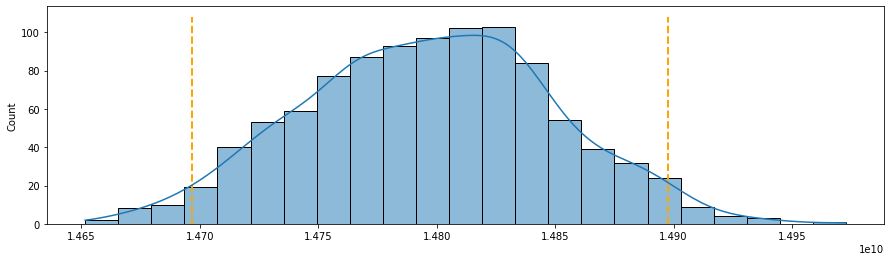

In [ ]:
fig, ax = plt.subplots(figsize=(15, 4))

sns.histplot(vals1, kde=True)

_, max_ylim = plt.ylim()
plt.vlines(interval1,
           color='orange',
           ymin=0,
           ymax=max_ylim,
           linestyle='--',
           linewidth=2)
print(f'interval = {interval1}');

Получим подвыборки и доверительный интервал для второго региона

In [ ]:
vals2, interval2 = bootstrap(pd.Series(second_region_top200), get_inc, alpha=0.05, count=1000)

Визуализируем результаты

interval = (10655105040.40481, 10730239402.24698)


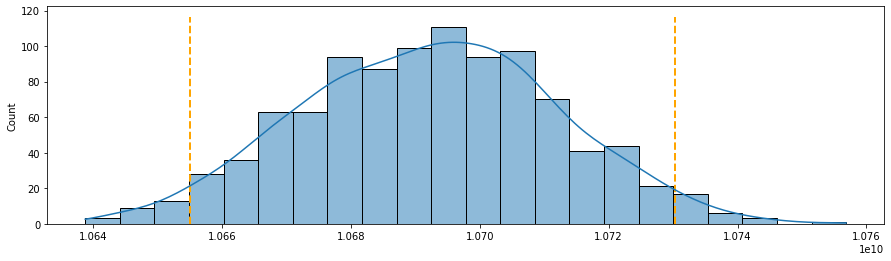

In [ ]:
fig, ax = plt.subplots(figsize=(15, 4))

sns.histplot(vals2, kde=True)

_, max_ylim = plt.ylim()
plt.vlines(interval2,
           color='orange',
           ymin=0,
           ymax=max_ylim,
           linestyle='--',
           linewidth=2)
print(f'interval = {interval2}');

Получим подвыборки и доверительный интервал для третьего региона

In [ ]:
vals3, interval3 = bootstrap(pd.Series(third_region_top200), get_inc, alpha=0.05, count=1000)

Визуализируем результаты

interval = (15130404437.238995, 15365159708.950754)


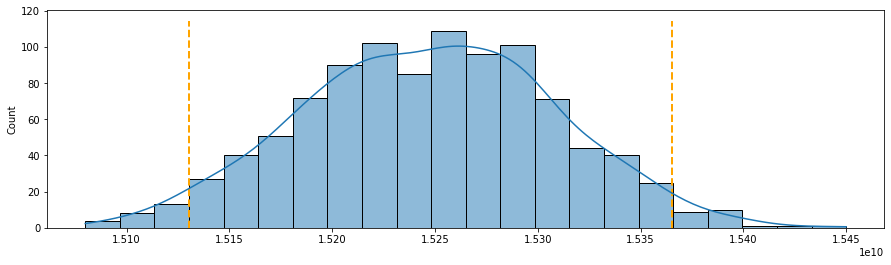

In [ ]:
fig, ax = plt.subplots(figsize=(15, 4))

sns.histplot(vals3, kde=True)

_, max_ylim = plt.ylim()
plt.vlines(interval3,
           color='orange',
           ymin=0,
           ymax=max_ylim,
           linestyle='--',
           linewidth=2)
print(f'interval = {interval3}');

Итак, все 3 доверительных интервала расположены правее значения 10 млрд, значит мы можем быть на 95% уверены в том, что работа окупится. При этом обе границы третьего интервала расположены правее относительно первых двух, т.е. этот регион, действительно, можно считать наиболее предпочтитительным

Риск убытков, кажется, отсутствует, т.к. даже самое левое значение в распределении превышает 10 млрд. Можно в этом более наглядно убедиться, выбрав минимальные значение в сгенерированных массивах прибылей

In [ ]:
min(vals1)

14651673807.334728

In [ ]:
min(vals2)

10638783987.436325

In [ ]:
min(vals3)

15079897005.46044

То есть за 1000 прогонов мы ни разу не получили прибыль менее 10 млрд. для всех трёх регионов

# Вывод

По итогам задачи предлагается пробурить 200 скважин в отобранных точках в регионе 3